In [1]:
# File processing
import glob
import os

# Data processing
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Data display 
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Machine learning
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy
from torch_geometric.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, InMemoryDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Constants

In [2]:
# Architecture constants
NB_BINS = 883
EMBEDDING_SIZE = 3 # Euclidean 3D space

# Loss constants
B_MIN = 0.133
B_MAX = 0.182
LAMBDA_PARAM = 1e-6

# Train/Test constants
SEED = 0
BATCH_SIZE = 1
NB_EPOCHS = 30
TRAIN_DATASET_SIZE = 1
TEST_DATASET_SIZE = 1
LEARNING_RATE = 0.001

# Dataset constants
GM12878_HIC_PATH = \
    '../../experiments/data/GM12878/KR_100kb/chr14_matrix.txt'

# Seeds

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Create dataset

## Hic matrices

In [4]:
import csv 

tsv_file = open(GM12878_HIC_PATH)
read_tsv = csv.reader(tsv_file, delimiter='\t')

gm12878_hic = np.zeros((NB_BINS, NB_BINS))
i = 0
for row in read_tsv:
    gm12878_hic[i, :] = row[:-1]
    i = i + 1
    
scaler = MinMaxScaler()
gm12878_hic = scaler.fit_transform(gm12878_hic) 

## Final dataset

### Training

In [7]:
class VanillaDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(VanillaDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['reach3d_gm12878_train_and_test_data.txt']

    def download(self):
        pass
        
    def process(self):
             
        hic_matrix = torch.FloatTensor(gm12878_hic)
        
        data = Data(hic_matrix=hic_matrix)
        data_list = [data]
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [8]:
train_dataset = VanillaDataset('../')

Processing...
Done!


In [9]:
train_size = len(train_dataset)
train_size

1

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

### Testing

In [11]:
test_dataset = VanillaDataset('../')

In [12]:
test_size = len(test_dataset)
test_size

1

In [13]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# LSTM Neural Network

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.lstm_encoder = torch.nn.LSTM(NB_BINS, EMBEDDING_SIZE, batch_first=True)
        self.lstm_decoder = torch.nn.LSTM(EMBEDDING_SIZE, NB_BINS, batch_first=True)
        
        self.xavier_initializer(self.lstm_encoder)
        self.xavier_initializer(self.lstm_decoder)
        
    def forward(self, x):
        
        x = torch.reshape(x, (-1, NB_BINS, NB_BINS))
        
        z, (h1, c1) = self.lstm_encoder(x)
        y, (h2, c2) = self.lstm_decoder(z)

        return y, z
    
    def xavier_initializer(self, module):
        
        for name, param in module.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_normal_(param)

# Procruste analysis functions

### Numpy

In [15]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [16]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [17]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [18]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [19]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

# Train and test

In [20]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
def vanilla_loss(pred_hic, true_hic, pred_structure, lambda_param, b_min, b_max):
    
    reconstruction_loss = torch.mean((pred_hic - true_hic)**2)
    
    z_shift = torch.roll(pred_structure, -1, 1)
    z_dist = pred_structure - z_shift
    z_dist = z_dist[:,:-1,:]
    z_dist = torch.sum(torch.square(z_dist), axis=2)
    
    min_bound_loss = torch.mean(b_min*b_min - z_dist)
    max_bound_loss = torch.mean(z_dist - b_max*b_max)
    
    distance_loss = min_bound_loss + max_bound_loss
    
    total_loss = reconstruction_loss + lambda_param * distance_loss
    
    return total_loss, reconstruction_loss, min_bound_loss, max_bound_loss

In [22]:
def structure_analysis(pred_structure):
    
    kabsch_distances = []
    for true_structure in trussart_structures:
        kabsch_distances.append(kabsch_distance_numpy(pred_structure, true_structure))
        
    return np.mean(kabsch_distances)

In [23]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        pred_hic, pred_structure = model(data.hic_matrix)
        pred_hic = torch.reshape(pred_hic, (-1, NB_BINS))
        
        true_hic = data.hic_matrix.to(device)
        
        total_loss, reconstruction_loss, min_bound_loss, max_bound_loss =  \
            vanilla_loss(pred_hic, true_hic, pred_structure, LAMBDA_PARAM, B_MIN, B_MAX)
        total_loss.backward()
        
        loss_all += data.num_graphs * total_loss.item()
        optimizer.step()
        
    return loss_all / len(train_dataset)

In [24]:
def evaluate(loader):
    model.eval()

    pred_hics = []
    true_hics = []
    
    pred_structures = []
    
    losses = defaultdict(list)

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred_hic, pred_structure = model(data.hic_matrix)
            
            pred_hic = pred_hic.detach().cpu()
            pred_structure = pred_structure.detach().cpu()
            
            pred_hic = torch.reshape(pred_hic, (-1, NB_BINS))
            true_hic = data.hic_matrix.detach().cpu()
            
            total_loss, reconstruction_loss, min_bound_loss, max_bound_loss = \
                vanilla_loss(pred_hic, true_hic, pred_structure, LAMBDA_PARAM, B_MIN, B_MAX)
            
            losses['total_loss'].append(total_loss)
            losses['reconstruction_loss'].append(reconstruction_loss)
            losses['min_bound_loss'].append(min_bound_loss)
            losses['max_bound_loss'].append(max_bound_loss)
            
            pred_hic = pred_hic.numpy()
            true_hic = true_hic.numpy()
            pred_structure = pred_structure.numpy()
            
            pred_hics.append(pred_hic)
            true_hics.append(true_hic)
            pred_structures.append(pred_structure)
            
    pred_hics = np.vstack(pred_hic)
    true_hics = np.vstack(true_hic)
    pred_structures = np.vstack(pred_structure)
    
    for loss_type, loss_value in losses.items():
        losses[loss_type] = np.mean(loss_value)
    
    return losses, pred_hics, true_hics, pred_structures

In [25]:
loss_results = defaultdict(list)

for epoch in range(1, 1+NB_EPOCHS):
    loss = train()

    train_losses, train_predictions, train_ground_truths, train_predicition_latent_values = \
        evaluate(train_loader)  

    test_losses, test_predictions, test_ground_truths, test_predicition_latent_values = \
        evaluate(test_loader)

    loss_results['total_loss'].append(test_losses['total_loss'])
    loss_results['reconstruction_loss'].append(test_losses['reconstruction_loss'])
    loss_results['min_bound_loss'].append(test_losses['min_bound_loss'])
    loss_results['max_bound_loss'].append(test_losses['max_bound_loss'])
    
    print('Epoch: {:03d}, Tl: {:.5f}, Rl: {:.5f}, Minl: {:.5f}, Maxl: {:.5f}'.
         format(epoch, test_losses['total_loss'], test_losses['reconstruction_loss'], \
                test_losses['min_bound_loss'], test_losses['max_bound_loss']))

Epoch: 001, Tl: 0.00151, Rl: 0.00151, Minl: 0.01728, Maxl: -0.03272
Epoch: 002, Tl: 0.00150, Rl: 0.00150, Minl: 0.01728, Maxl: -0.03272
Epoch: 003, Tl: 0.00150, Rl: 0.00150, Minl: 0.01728, Maxl: -0.03272
Epoch: 004, Tl: 0.00150, Rl: 0.00150, Minl: 0.01728, Maxl: -0.03272
Epoch: 005, Tl: 0.00150, Rl: 0.00150, Minl: 0.01728, Maxl: -0.03272
Epoch: 006, Tl: 0.00149, Rl: 0.00149, Minl: 0.01728, Maxl: -0.03271
Epoch: 007, Tl: 0.00149, Rl: 0.00149, Minl: 0.01728, Maxl: -0.03271
Epoch: 008, Tl: 0.00149, Rl: 0.00149, Minl: 0.01727, Maxl: -0.03271
Epoch: 009, Tl: 0.00149, Rl: 0.00149, Minl: 0.01727, Maxl: -0.03271
Epoch: 010, Tl: 0.00149, Rl: 0.00149, Minl: 0.01727, Maxl: -0.03270
Epoch: 011, Tl: 0.00149, Rl: 0.00149, Minl: 0.01727, Maxl: -0.03270
Epoch: 012, Tl: 0.00149, Rl: 0.00149, Minl: 0.01726, Maxl: -0.03270
Epoch: 013, Tl: 0.00149, Rl: 0.00149, Minl: 0.01726, Maxl: -0.03269
Epoch: 014, Tl: 0.00149, Rl: 0.00149, Minl: 0.01725, Maxl: -0.03269
Epoch: 015, Tl: 0.00149, Rl: 0.00149, Minl: 0.01

# Model evaluation

### Total Loss and Loss decomposition

[Text(0.5, 0, 'Number of epochs'), Text(0, 0.5, 'Max bound loss')]

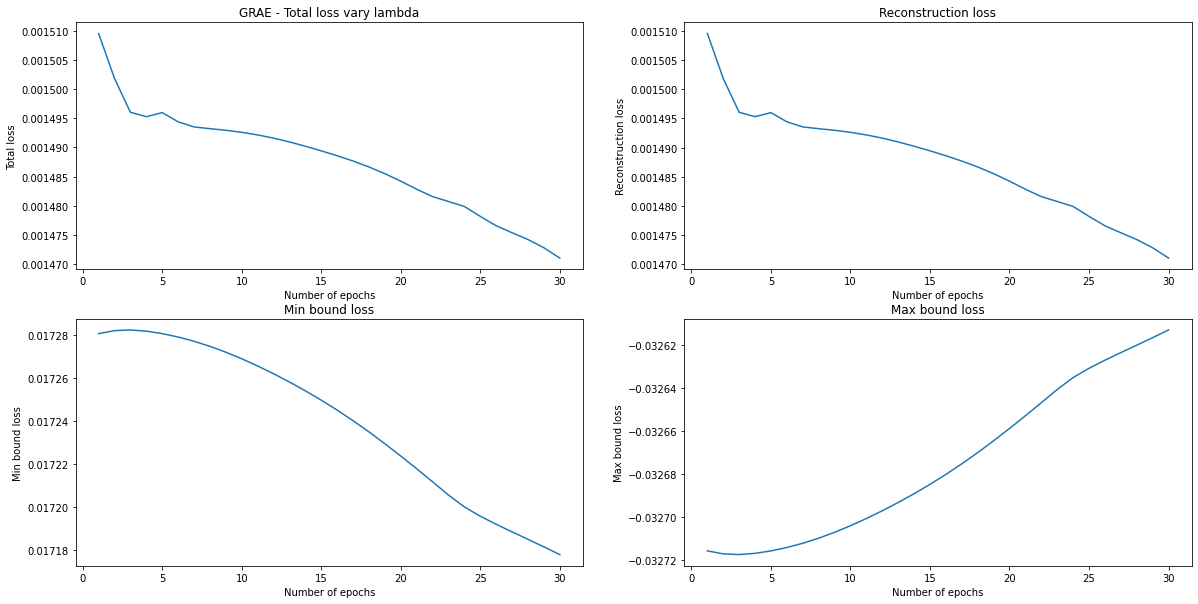

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

axs[0, 0].plot(range(1, NB_EPOCHS+1), loss_results['total_loss'])
axs[0, 0].set_title('GRAE - Total loss vary lambda')
axs[0, 0].set(xlabel='Number of epochs', ylabel='Total loss')
# axs[0, 0].set_xlim([0, 350])
# axs[0, 0].set_ylim([0.005, 0.035])

axs[0, 1].plot(range(1, NB_EPOCHS+1), loss_results['reconstruction_loss'])
axs[0, 1].set_title('Reconstruction loss')
axs[0, 1].set(xlabel='Number of epochs', ylabel='Reconstruction loss')
# axs[0, 1].set_xlim([0, 350])
# axs[0, 1].set_ylim([0.005, 0.035])

axs[1, 0].plot(range(1, NB_EPOCHS+1), loss_results['min_bound_loss'])
axs[1, 0].set_title('Min bound loss')
axs[1, 0].set(xlabel='Number of epochs', ylabel='Min bound loss')
# axs[1, 0].set_xlim([0, 350])
# axs[1, 0].set_ylim([0.025, 0.055])

axs[1, 1].plot(range(1, NB_EPOCHS+1), loss_results['max_bound_loss'])
axs[1, 1].set_title('Max bound loss')
axs[1, 1].set(xlabel='Number of epochs', ylabel='Max bound loss')
# axs[1, 1].set_xlim([0, 350])
# axs[1, 1].set_ylim([0.06, 0.16])

### HiC matrix reconstruction

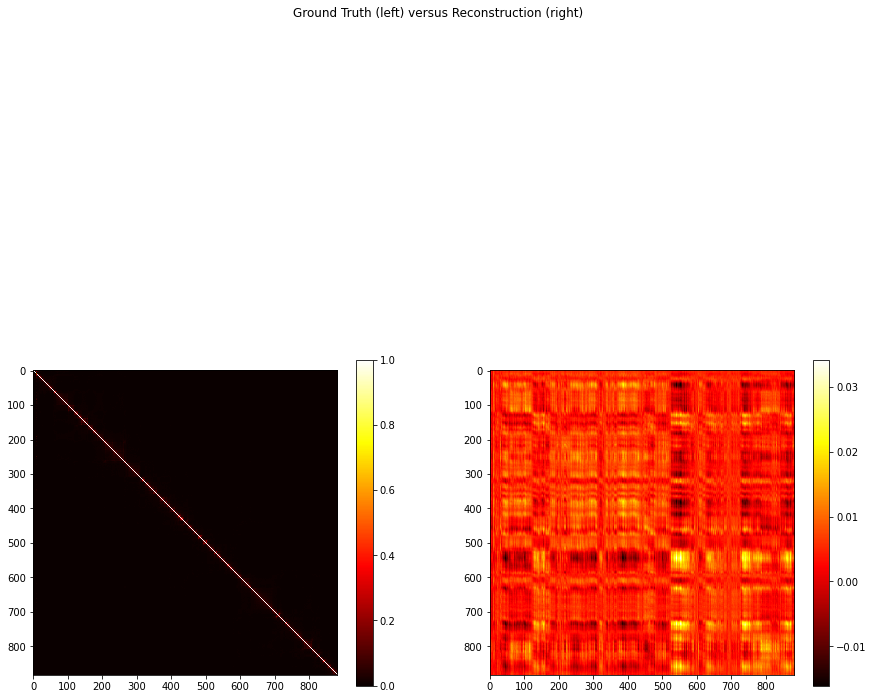

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))
fig.suptitle('Ground Truth (left) versus Reconstruction (right)')

im = axes[0].imshow(test_ground_truths, cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=axes[0], shrink=0.4)

im = axes[1].imshow(test_predictions, cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=axes[1], shrink=0.4)

plt.show()

### Inferred structures

In [28]:
latent_values = centralize_and_normalize_numpy(test_predicition_latent_values)

In [29]:
x_pred = latent_values[:, 0]  
y_pred = latent_values[:, 1]
z_pred = latent_values[:, 2]

In [31]:
# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_pred))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.update_layout(
    height=1000,
    width=1000
)

fig.show()

# Save losses

In [ ]:
np.savetxt('reach3d_gm12878_test_structure_losses_all_epochs.txt', loss_results['mean_kabsch_distance'])

# Save output structures

In [ ]:
np.savetxt('reach3d_gm12878_output_structure.txt', latent_values, delimiter='\t')